# Image Denoising
This tutorial gives insights into the task of image denoising. The goal is to recover the clean image $u$, which is corrupted by additive Gaussian white noise $n$, given the noisy measurement data $f$,
$$ f = u + n. $$

The tutorial covers following denoising approaches:
- Denoising with Tikhonov regularization
- Denoising with Total Variation (TV) regularization
- Denoising with a deep neural network

## Preparation
First, we download the standard denoising testset `Set12`.

In [3]:
import os

# Download Set12
for i in range(1, 13):
    if not os.path.exists(f'./data/denoising/Set12/{i:02d}.png'):
        os.system(f'wget https://raw.githubusercontent.com/cszn/DnCNN/master/TrainingCodes/dncnn_keras/data/Test/Set12/{i:02d}.png -P ./data/denoising/Set12/')

--2021-10-26 11:15:19--  https://raw.githubusercontent.com/cszn/DnCNN/master/TrainingCodes/dncnn_keras/data/Test/Set12/01.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38267 (37K) [image/png]
Saving to: ‘./data/denoising/Set12/01.png’

     0K .......... .......... .......... .......              100% 3,47M=0,01s

2021-10-26 11:15:19 (3,47 MB/s) - ‘./data/denoising/Set12/01.png’ saved [38267/38267]

--2021-10-26 11:15:19--  https://raw.githubusercontent.com/cszn/DnCNN/master/TrainingCodes/dncnn_keras/data/Test/Set12/02.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP req

HTTP request sent, awaiting response... 200 OK
Length: 193637 (189K) [image/png]
Saving to: ‘./data/denoising/Set12/12.png’

     0K .......... .......... .......... .......... .......... 26% 1,95M 0s
    50K .......... .......... .......... .......... .......... 52% 2,25M 0s
   100K .......... .......... .......... .......... .......... 79% 8,95M 0s
   150K .......... .......... .......... .........            100% 8,35M=0,06s

2021-10-26 11:15:23 (3,25 MB/s) - ‘./data/denoising/Set12/12.png’ saved [193637/193637]



Next, we load a single image and prepare it for image denoising by normalizing it to the range $[0,1]$.

Text(0.5, 1.0, 'Original Image')

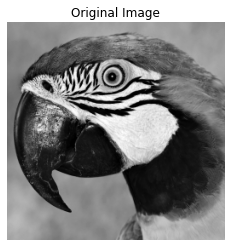

In [5]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

img = imageio.imread('./data/denoising/Set12/07.png', as_gray=True)

# convert to float and normalize from [0, 255] to [0, 1]
img = img.astype(np.float32) / 255.0

# show image
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Original Image')

To compare the quality of the denoising algorithms, we compute the Peak Signal to Noise ratio (PSNR) in dB as follows:
$$ \text{PSNR} = 10 \log_{10} \left(\frac{\text{max_intensity}^2}{\text{MSE}}\right),$$
where the Mean-Squared error (MSE) is defined as:
$$ \text{MSE} = \sum_{i\in\Omega} \vert u_{\text{ref},i} - u_i \vert^2. $$
Here, $u_{\text{ref}}$ defines the target (reference) image, $u$ the source image, e.g., noisy or denoised image, and $i$ denote the pixels in domain $\Omega$.


Isn't the MSE missing the normalization term?
$$ \text{MSE} = \frac{1}{n} \sum_{i\in\Omega} \vert u_{\text{ref},i} - u_i \vert^2. $$

In [6]:
def psnr(x, x_ref, max_intensity=1.0):
    """
    Compute the Peak Signal to Noise ratio (PSNR) in dB
    Args:
        x (np.array): predicted image
        x_ref (np.array): target image
    Return:
        float: Computed metric
    """
    return 10 * np.log10(max_intensity ** 2 / np.mean((x_ref-x)**2))

Now we generate a noisy image $f$ by adding Gaussian white noise of standard deviation $\sigma$.

Text(0.5, 1.0, 'Noisy Image sigma=25 PSNR=20.20 (dB)')

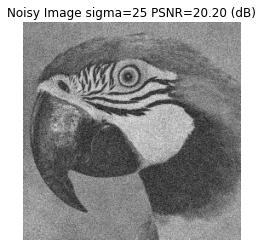

In [7]:
# noise level for domain [0, 255]
sigma = 25

# generate noisy image
noisy = img + sigma / 255.0 * np.random.randn(*img.shape)

# plot noisy image
plt.imshow(noisy, cmap='gray')
plt.axis('off')
plt.title(f'Noisy Image sigma={sigma} PSNR={psnr(noisy, img):0.2f} (dB)')

## Tikhonov regularization
We regularize the least-squares problem with a Tikhonov regularizer of form $\mathcal{R}(u)=\frac{1}{2} \Vert \nabla u \Vert_2^2$, resulting in following minimization problem.

$$ \min_u \frac{1}{2} \Vert u - f \Vert_2^2 + \frac{\lambda}{2} \Vert \nabla u \Vert_2^2$$

The solution is given as:

$$ u - f + \lambda\nabla^\top \nabla u = 0 $$
$$ u = (I + \lambda \nabla^\top \nabla)^{-1} f $$

In [8]:
import scipy.sparse
import scipy.sparse.linalg

def nabla_matrix(M, N):
    """ Generates the nabla matrix for a 2D image of size [M, N] """
    size = M * N
    row = np.arange(0, size)
    col = np.arange(0, size).reshape(M, N)
    fill = np.ones(size)
    col_fwd_x = np.pad(col[:,1:], [[0, 0],[0, 1]], mode='edge')
    col_bwd_y = np.pad(col[1:], [[0, 1],[0, 0]], mode='edge')
    
    dx = scipy.sparse.coo_matrix((fill, (row, col_fwd_x.flatten())), shape=(size, size)) - \
         scipy.sparse.coo_matrix((fill, (row, col.flatten())), shape=(size, size))

    dy = scipy.sparse.coo_matrix((fill, (row, col_bwd_y.flatten())), shape=(size, size)) - \
         scipy.sparse.coo_matrix((fill, (row, col.flatten())), shape=(size, size))
    
    return scipy.sparse.vstack([dx, dy])

def tikhonov(u, alpha):
    """ Solve linear system of equations. """
    D = nabla_matrix(*u.shape)
    v = scipy.sparse.linalg.spsolve(scipy.sparse.eye(u.size) + alpha * D.T @ D, u.flatten())
    return np.reshape(v, u.shape)

Text(0.5, 1.0, 'Denoised Tikhonov alpha=1 PSNR=24.66 (dB)')

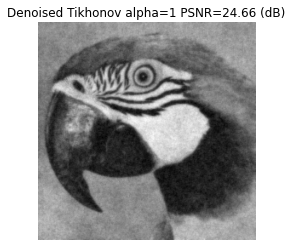

In [9]:
alpha = 1 # regularization parameter
denoised_tikhonov = tikhonov(noisy, alpha=alpha)

# plot
plt.imshow(denoised_tikhonov, cmap='gray')
plt.axis('off')
plt.title(f'Denoised Tikhonov alpha={alpha} PSNR={psnr(denoised_tikhonov, img):0.2f} (dB)')

## Denoising with Total Variation regularization.
We see that the quadratic regularizer smoothes the entire image. To alleviate this issue, a total variation (TV) regularizer can be used. The TV is given as
$$ \mathcal{R}(u) = \Vert \nabla u \Vert_{2,1} = \sum_{i\in\Omega} \sqrt{(\nabla_x u_i)^2 + (\nabla_y u_i)^2},$$ known as the ROF model, proposed by Rudin, Osher and Fatemi.
Here, $\nabla$ approximates the image gradient with finite forward differences.
The TV regularizer approximates sparsity in the image edges and favors piece-wise constant solutions.

$$ \min_u \frac{\lambda}{2} \Vert u - f \Vert + \Vert \nabla u \Vert_{2,1} $$

### Primal-Dual Algorithm
One famous algorithm to solve above problem is the [Primal-Dual Algorithm](https://link.springer.com/article/10.1007/s10851-010-0251-1) (Chambolle & Pock, 2010). We only roughly outline the primal-dual algorithm in this tutorial. More information are found in the original publication Section 6.2.1.

Consider the saddle-point problem
$$ \min_u \max_p \langle \nabla u, p \rangle + \frac{\lambda}{2}\Vert u - f \Vert_2^2 - \delta_
{\Vert p \Vert_{\infty} \leq 1}(p).$$


Set $\tau \sigma L \leq 1$, where $L$ is the Lipschitz constant, $\tau$ is the primal stepsize and $\sigma$ is the dual stepsize, respectively. Initialize $p^0=0$, $u^0=f$, $\bar{u}^0=f$. Set regularization parameter $\lambda$ and maximum number of iterations $N_k$.

For $0 \leq k < N_k$ do:

1. Perform dual update
$$ \hat{p}^{k+1} = p^{k} + \sigma \nabla \bar{u}^k$$

2. Perform projection onto infinity ball
$$ p^{k+1} = \frac{\hat{p}^{k+1}}{\max{\left(\Vert \hat{p}^{k+1} \Vert_2, 1\right)}}$$

3. Perform primal update
$$ \hat{u}^{k+1} = u^{k} - \tau \nabla^\top p^{k+1} $$ 

4. Solve proximal mapping 
$$ u^{k+1} = \arg \min_u \frac{1}{\tau} \Vert u - \hat{u}^{k+1} \Vert_2^2 + \frac{\lambda}{2}\Vert u - f\Vert_2^2 $$
which results in the update
$$ u^{k+1} = \frac{\hat{u}^{k+1} + \tau \lambda f
}{1 + \tau\lambda} $$

5. Overrelaxation
$$ \bar{u}^{k+1} = u^{k+1} + \theta (u^{k+1} - u^{k})$$

In [10]:
def nabla(x):
    dx = np.pad(x[:,1:], [[0, 0],[0, 1]], mode='edge')
    dy = np.pad(x[1:], [[0, 1],[0, 0]], mode='edge')
    return np.concatenate([dx[None,...] - x, dy[None,...] - x], 0)

def nablaT(x):
    assert x.shape[0] == 2
    dx = np.pad(x[0,:,:-1], [[0, 0],[1, 0]], mode='constant')
    dy = np.pad(x[1,:-1], [[1, 0],[0, 0]], mode='constant')
    return dx - x[0] + dy - x[1] 

def primal_dual(f, alpha, max_iter):
    p = np.zeros_like(nabla(f))
    u = f.copy()
    u_old = f.copy()
    u_bar = f.copy()

    L = 8.0
    sigma = 1.0 / np.sqrt(L)
    tau = 1.0 / np.sqrt(L)

    theta = 1.0

    for i in range(max_iter):
        # dual update
        p_ = p.copy() + sigma * nabla(u_bar)
        # dual projection
        norm_p = np.sqrt(p_[0]**2 + p_[1]**2)
        p = p_ / np.maximum(np.ones_like(norm_p), norm_p)
        # primal update
        u_ = u.copy() - tau * nablaT(p)
        # primal proximal step
        u = (u_ + tau * alpha * f) / (1 + tau * alpha)
        # over-relaxation
        u_bar = u + theta * (u - u_old)
        u_old = u.copy()
    return u

Text(0.5, 1.0, 'Denoised Primal-Dual alpha=10.0 max_iter=500 PSNR=27.22 (dB)')

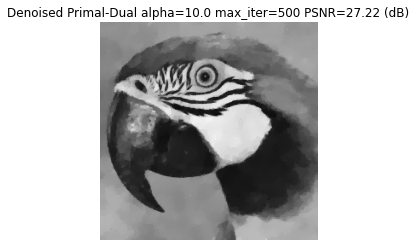

In [11]:
alpha = 10.0
max_iter = 500
denoised_pd = primal_dual(noisy, alpha=alpha, max_iter=max_iter)

# plot
plt.imshow(denoised_pd, cmap='gray')
plt.axis('off')
plt.title(f'Denoised Primal-Dual alpha={alpha} max_iter={max_iter} PSNR={psnr(denoised_pd, img):0.2f} (dB)')

## Image Denoising Network
The following code downloads the DnCNN denoising network and applies it to our image denoising task.

Zhang et al. [Beyond a Gaussian Denoiser: Residual Learning of Deep CNN for Image Denoising](https://ieeexplore.ieee.org/document/7839189). IEEE Transactions on Image Processing, vol. 26, no. 7, pp. 3142-3155, 2017.

In [16]:
import os
from tensorflow.keras.models import model_from_json

if not os.path.exists('./trained_models'):
    os.makedirs('./trained_models')

if not os.path.exists('./trained_models/dncnn.json'):
    os.system('wget https://raw.githubusercontent.com/cszn/DnCNN/master/TrainingCodes/dncnn_keras/models/DnCNN_sigma25/model.json -O ./trained_models/dncnn.json')

if not os.path.exists('./trained_models/dncnn.h5'):
    os.system('wget https://raw.githubusercontent.com/cszn/DnCNN/master/TrainingCodes/dncnn_keras/models/DnCNN_sigma25/model.h5 -O ./trained_models/dncnn.h5')
    
json_file = open('trained_models/dncnn.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights('./trained_models/dncnn.h5')

print(model.summary())

ModuleNotFoundError: No module named 'absl'

Text(0.5, 1.0, 'Denoised DnCNN PSNR=29.41 (dB)')

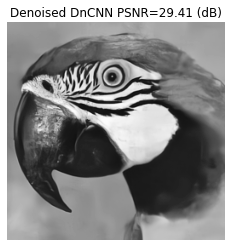

In [ ]:
def to_tf(x):
    return x[None,...,None]

def from_tf(x):
    return np.squeeze(x)

denoised_dncnn = from_tf(model.predict(to_tf(noisy)))

# plot
plt.imshow(denoised_dncnn, cmap='gray')
plt.axis('off')
plt.title(f'Denoised DnCNN PSNR={psnr(denoised_dncnn, img):0.2f} (dB)')